In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle


In [11]:
# 读取数据
data = pd.read_pickle("processed_data1.pkl")
data

,date_block_num,item_cnt_month,item_id,shop_id,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,average_item_cnt_month_lag_1,average_date_item_cnt_month_lag_1,average_date_item_cnt_month_lag_2,average_date_item_cnt_month_lag_3,average_date_item_cnt_month_lag_4,average_date_item_cnt_month_lag_5,average_date_item_cnt_month_lag_6,average_date_shop_item_cnt_month_lag_1,average_date_shop_item_cnt_month_lag_2,average_date_shop_item_cnt_month_lag_3,average_date_shop_item_cnt_month_lag_4,average_date_shop_item_cnt_month_lag_5,average_date_shop_item_cnt_month_lag_6,average_date_category_item_cnt_month_lag_1,average_date_shop_category_item_cnt_month_lag_1,average_date_shop_type_item_cnt_month_lag_1,average_date_shop_subtype_item_cnt_month_lag_1,average_date_city_item_cnt_month_lag_1,average_date_item_city_item_cnt_month_lag_1,average_date_type_item_cnt_month_lag_1,average_date_subtype_item_cnt_month_lag_1,delta_price_lag,delta_revenue_lag_1_x,delta_revenue_lag_1_y,delta_revenue_lag_2,delta_revenue_lag_3,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,0.0,27,2,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.086957,0.044444,0.130435,0.022222,0.022222,0.065217,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,1.082474,0.955326,0.808824,0.934844,0.148118,0.0,1.034303,1.075009,0.050100,1.211909,1.211909,0.382685,-0.161755,0,31,1,1,0,0
4488711,12,0.0,30,2,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,1.021739,1.022222,0.521739,0.288889,0.422222,0.891304,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.291505,0.046246,0.051719,0.046246,0.148118,0.0,0.269904,0.291505,-0.010316,1.211909,1.211909,0.382685,-0.161755,0,31,1,1,0,0
4488712,12,0.0,31,2,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.543478,0.600000,0.543478,0.422222,0.555556,0.304348,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.232808,0.059459,0.051719,0.064690,0.148118,0.0,0.269904,0.233994,-0.021287,1.211909,1.211909,0.382685,-0.161755,0,31,1,1,0,0
4488713,12,1.0,32,2,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,1.934783,1.800000,1.260870,1.311111,1.600000,1.891304,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.291505,0.046246,0.051719,0.046246,0.148118,0.0,0.269904,0.291505,0.022693,1.211909,1.211909,0.382685,-0.161755,0,31,-1,1,0,0
4488714,12,1.0,33,2,0,37,11,1,1.0,2.0,0.0,0.0,0.0,0.0,0.411299,0.913043,0.333333,0.717391,0.955556,0.777778,1.000000,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.232808,0.059459,0.051719,0.064690,0.148118,1.0,0.269904,0.233994,-0.008040,1.211909,1.211909,0.382685,-0.161755,0,31,1,1,0,0
4488715,12,0.0,34,2,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.108696,0.022222,0.043478,0.200000,0.266667,0.260870,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.291505,0.046246,0.051719,0.046246,0.148118,0.0,0.269904,0.291505,-0.097987,1.211909,1.211909,0.382685,-0.161755,0,31,-1,1,0,0
4488716,12,0.0,36,2,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.130435,0.088889,0.130435,0.088889,0.066667,0.108696,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.232808,0.059459,0.051719,0.064690,0.148118,0.0,0.269904,0.233994,0.000000,1.211909,1.211909,0.382685,-0.161755,0,31,-1,1,0,0
4488717,12,0.0,37,2,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.173913,0.266667,0.195652,0.288889,0.333333,0.217391,0.148118,0.10063,0.089066,0.107034,0.106089,0.096014,0.291505,0.046246,0.051719,0.046246,0.148118,0.0,0.269904,0.291505,0.110283,1.211909,1.211909,0.382685,-0.161755,0,31,-1,1,0,0
4488718,12,0.0,39,2,0,41,11,35,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,0.148118,0.00000,0.000000,0.000000,0.000000,0.000000,0.248600,0.030675,0.051719,0.030675,0.148118,0.0,0.269904,0.248600,0.000000,1.211909,1.211909,NaN,NaN,0,31,-1,1,0,0
4488719,12,0.0,40,2,0,57,13,8,0.0,0.0,0.0,0.0,0.0,0.0,0.411299,0.108696,0.044444,0.108696,0.088889,0.066667,0.086957,0

In [12]:
# 选择合适的列来训练
# 某些列的相关系数可能是负的
data_ = data[["date_block_num", 
             "shop_id", 
             "item_id",
             "item_cnt_month", 
             "city_code",
             "item_category_id", 
             "type_code",
             "subtype_code",
             "item_cnt_month_lag_1",
             "item_cnt_month_lag_2",
             "item_cnt_month_lag_3", 
             "item_cnt_month_lag_4",
             "item_cnt_month_lag_5",
             "item_cnt_month_lag_6",
             "average_item_cnt_month_lag_1",
             'average_date_item_cnt_month_lag_1',
             'average_date_item_cnt_month_lag_2',
             'average_date_item_cnt_month_lag_3',
             'average_date_item_cnt_month_lag_4',
             'average_date_item_cnt_month_lag_5',
              'average_date_item_cnt_month_lag_6',
              "average_date_shop_item_cnt_month_lag_1",
              "average_date_shop_item_cnt_month_lag_2",
              "average_date_shop_item_cnt_month_lag_3",
              "average_date_shop_item_cnt_month_lag_4",
              "average_date_shop_item_cnt_month_lag_5",
              "average_date_shop_item_cnt_month_lag_6",
              "average_date_category_item_cnt_month_lag_1",
              "average_date_shop_category_item_cnt_month_lag_1",
              "average_date_shop_type_item_cnt_month_lag_1",
              "average_date_shop_subtype_item_cnt_month_lag_1",
              "average_date_city_item_cnt_month_lag_1",
              "average_date_item_city_item_cnt_month_lag_1",
              'average_date_type_item_cnt_month_lag_1',
              'average_date_subtype_item_cnt_month_lag_1',
              "delta_price_lag",
              "delta_revenue_lag_1_x",  # 这里应该应该执行了两次
              "delta_revenue_lag_2",
              "delta_revenue_lag_3",
              "month",
              "days",
              'item_shop_last_sale',
              'item_last_sale', 
              'item_shop_first_sale', 
              'item_first_sale',             
             ]]

In [13]:
# date_block_num为34的内容作为测试集，
# 13-32的内容为训练集，选择33的内容为训练数据的测试集
ts = time.time()
X_train = data_[data_["date_block_num"] < 33].drop(["item_cnt_month"], axis=1)
y_train = data_[data_["date_block_num"] < 33]["item_cnt_month"]
X_valid = data_[data_["date_block_num"] == 33].drop(["item_cnt_month"], axis=1)
y_valid = data_[data_["date_block_num"] == 33]["item_cnt_month"]

X_test = data_[data_["date_block_num"] == 34].drop(["item_cnt_month"], axis=1)

time.time() - ts

8.759570837020874

In [14]:
del data
del data_
gc.collect()

156

In [6]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR

In [6]:
ts = time.time()
XGBmodel = XGBRegressor(max_depth=12,
                     n_estimators=3000, 
                     min_child_weight=300,
                     colsample_bytree=0.7,
                    colsample_bylevel=0.9,
                     subsample=0.8,
                     learn_rate=0.05,
                     seed=42,
                     n_jobs=-1,   
                   
                    )

XGBmodel.fit(X_train, 
          y_train, 
          eval_metric="rmse", 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          verbose=True,
         early_stopping_rounds=10)

time.time() - ts

[18:27:04] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.14862	validation_1-rmse:1.11684
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10035	validation_1-rmse:1.08175
[2]	validation_0-rmse:1.05988	validation_1-rmse:1.05273
[3]	validation_0-rmse:1.0227	validation_1-rmse:1.02506
[4]	validation_0-rmse:0.991791	validation_1-rmse:1.00499
[5]	validation_0-rmse:0.968175	validation_1-rmse:0.988634
[6]	validation_0-rmse:0.94423	validation_1-rmse:0.973624
[7]	validation_0-rmse:0.923611	validation_1-rmse:0.961236
[8]	validation_0-rmse:0.906631	validation_1-rmse:0.950327
[9]	validation_0-rmse:0.892551	validation_1-rmse:0.94164
[10]	validation_0-rmse:0.879043	validation_1-rmse:0.934125
[11]	validation_0-rmse:0.868178	validation

1309.7408723831177

In [16]:
# ts = time.time()
# model = XGBRegressor()
# param_grid = [{"learning_rate": [0.005, 0.01, 0.05, 0.1]}]
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
# grid_search = GridSearchCV(model, param_grid=param_grid, scoring="neg_log_loss", n_jobs=2, cv=kfold)
# grid_result = grid_search.fit(X_train, y_train)

# time.time() - ts

JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...ow_1\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\runpy.py in _run_code(code=<code object <module> at 0x0000021A62CFE5D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'D:\Anaconda3\envs\tensorflow_1\lib\site-packages\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ow_1\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'D:\\Anaconda..._1\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...ow_1\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000021A62CFE5D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'D:\Anaconda3\envs\tensorflow_1\lib\site-packages\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ow_1\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'D:\\Anaconda..._1\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1420                         logger.warning('Executing %s took %.3f seconds',
   1421                                        _format_handle(handle), dt)
   1422                 finally:
   1423                     self._current_handle = None
   1424             else:
-> 1425                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(280, 1)>>
   1426         handle = None  # Needed to break cycles when an exception occurs.
   1427 
   1428     def _set_coroutine_wrapper(self, enabled):
   1429         try:

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(280, 1)>)
    122             self._callback = None
    123             self._args = None
    124 
    125     def _run(self):
    126         try:
--> 127             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (280, 1)
    128         except Exception as exc:
    129             cb = _format_callback_source(self._callback, self._args)
    130             msg = 'Exception in callback {}'.format(cb)
    131             context = {

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=280, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 19, 3, 45, 31, 676226, tzinfo=tzutc()), 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'session': '31c29aeccbbc4b3bb0cea3965c45aa7a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'31c29aeccbbc4b3bb0cea3965c45aa7a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 19, 3, 45, 31, 676226, tzinfo=tzutc()), 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'session': '31c29aeccbbc4b3bb0cea3965c45aa7a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'31c29aeccbbc4b3bb0cea3965c45aa7a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 19, 3, 45, 31, 676226, tzinfo=tzutc()), 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'session': '31c29aeccbbc4b3bb0cea3965c45aa7a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '9773ab155e2747f18fde02626dfe1d1d', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-16-9ee9d20f97c2>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 21a009eccf8, executio...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000021A009A76F0, file "<ipython-input-16-9ee9d20f97c2>", line 6>
        result = <ExecutionResult object at 21a009eccf8, executio...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000021A009A76F0, file "<ipython-input-16-9ee9d20f97c2>", line 6>, result=<ExecutionResult object at 21a009eccf8, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000021A009A76F0, file "<ipython-input-16-9ee9d20f97c2>", line 6>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\npd.set_op...)\n\nimport time\nimport sys\nimport gc\nimport pickle', '# 读取数据\ndata = pd.read_pickle("processed_data.pkl")\ndata', '# 选择合适的列来训练\n# 某些列的相关系数可能是负的\ndata_ = data[["date_...  \'item_first_sale\',             \n             ]]', '# date_block_num为34的内容作为测试集，\n# 13-32的内容为训练集，选择33...ock_num"] == 34].drop(["item_cnt_month"], axis=1)', 'del data\ndel data_\ngc.collect()', 'ts = time.time()\nXGBmodel = XGBRegressor(max_dep...       early_stopping_rounds=8)\n\ntime.time() - ts', '# 预测\nts = time.time()\ntest = pd.read_csv("test.c...ot_features(XGBmodel, (10, 14))\n\ntime.time() - ts', 'gc.collect()', '# use grid search\nts = time.time()\nparam_grid = ...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'gc.collect()', 'ts = time.time()\nXGBmodel = XGBRegressor(max_dep...       early_stopping_rounds=8)\n\ntime.time() - ts', '# 预测\nts = time.time()\ntest = pd.read_csv("test.c...ot_features(XGBmodel, (10, 14))\n\ntime.time() - ts', 'gc.collect()', 'from sklearn.model_selection import GridSearchCV...ndomForestRegressor\n# from sklearn.svm import SVR', 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts'], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {2:           date_block_num  item_cnt_month  item_i...7               17  

[6639294 rows x 41 columns], 5: 18, 6: 450.47183108329773, 7: 7.303637266159058, 8: 7812, 10: 0, 11: 1242.0473217964172, 12: 3.3590476512908936, 13: 7830}, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'XGBRegressor': <class 'xgboost.sklearn.XGBRegressor'>, 'XGBmodel': XGBRegressor(base_score=0.5, booster='gbtree', c...ht=1, seed=42, silent=True,
       subsample=0.8), 'X_test':           date_block_num  shop_id  item_id  city...17               17  

[214200 rows x 40 columns], 'X_train':           date_block_num  shop_id  item_id  city...4               24  

[6186922 rows x 40 columns], 'X_valid':           date_block_num  shop_id  item_id  city...25               25  

[238172 rows x 40 columns], ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\npd.set_op...)\n\nimport time\nimport sys\nimport gc\nimport pickle', '# 读取数据\ndata = pd.read_pickle("processed_data.pkl")\ndata', '# 选择合适的列来训练\n# 某些列的相关系数可能是负的\ndata_ = data[["date_...  \'item_first_sale\',             \n             ]]', '# date_block_num为34的内容作为测试集，\n# 13-32的内容为训练集，选择33...ock_num"] == 34].drop(["item_cnt_month"], axis=1)', 'del data\ndel data_\ngc.collect()', 'ts = time.time()\nXGBmodel = XGBRegressor(max_dep...       early_stopping_rounds=8)\n\ntime.time() - ts', '# 预测\nts = time.time()\ntest = pd.read_csv("test.c...ot_features(XGBmodel, (10, 14))\n\ntime.time() - ts', 'gc.collect()', '# use grid search\nts = time.time()\nparam_grid = ...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'gc.collect()', 'ts = time.time()\nXGBmodel = XGBRegressor(max_dep...       early_stopping_rounds=8)\n\ntime.time() - ts', '# 预测\nts = time.time()\ntest = pd.read_csv("test.c...ot_features(XGBmodel, (10, 14))\n\ntime.time() - ts', 'gc.collect()', 'from sklearn.model_selection import GridSearchCV...ndomForestRegressor\n# from sklearn.svm import SVR', 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts', 'ts = time.time()\nmodel = XGBRegressor()\nparam_gr...id_search.fit(X_train, y_train)\n\ntime.time() - ts'], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {2:           date_block_num  item_cnt_month  item_i...7               17  

[6639294 rows x 41 columns], 5: 18, 6: 450.47183108329773, 7: 7.303637266159058, 8: 7812, 10: 0, 11: 1242.0473217964172, 12: 3.3590476512908936, 13: 7830}, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'XGBRegressor': <class 'xgboost.sklearn.XGBRegressor'>, 'XGBmodel': XGBRegressor(base_score=0.5, booster='gbtree', c...ht=1, seed=42, silent=True,
       subsample=0.8), 'X_test':           date_block_num  shop_id  item_id  city...17               17  

[214200 rows x 40 columns], 'X_train':           date_block_num  shop_id  item_id  city...4               24  

[6186922 rows x 40 columns], 'X_valid':           date_block_num  shop_id  item_id  city...25               25  

[238172 rows x 40 columns], ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\86784\Desktop\python\ipython\10_7\<ipython-input-16-9ee9d20f97c2> in <module>()
      1 ts = time.time()
      2 model = XGBRegressor()
      3 param_grid = [{"learning_rate": [0.005, 0.01, 0.05, 0.1]}]
      4 kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
      5 grid_search = GridSearchCV(model, param_grid=param_grid, scoring="neg_log_loss", n_jobs=2, cv=kfold)
----> 6 grid_result = grid_search.fit(X_train, y_train)
      7 
      8 time.time() - ts

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=StratifiedKFold(n_splits=10, ran...'warn',
       scoring='neg_log_loss', verbose=0), X=          date_block_num  shop_id  item_id  city...4               24  

[6186922 rows x 40 columns], y=4488710      0.0
4488711      0.0
4488712      0...: item_cnt_month, Length: 6186922, dtype: float32, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of StratifiedKFold(n_splits=10, random_state=17, shuffle=True)>
        X =           date_block_num  shop_id  item_id  city...4               24  

[6186922 rows x 40 columns]
        y = 4488710      0.0
4488711      0.0
4488712      0...: item_cnt_month, Length: 6186922, dtype: float32
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Fri Oct 19 11:45:48 2018
PID: 18684          Python 3.5.5: D:\Anaconda3\envs\tensorflow_1\python.exe
...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBRegressor(base_score=0.5, booster='gbtree', c...ht=1, seed=None,
       silent=True, subsample=1),           date_block_num  shop_id  item_id      ... 24               24

[6186922 rows x 40 columns], 4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 6186922, dtype: float32, {'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, memmap([      0,       1,       2, ..., 6186917, 6186918, 6186919]), memmap([      5,      12,      14, ..., 6186908, 6186920, 6186921]), 0, {'learning_rate': 0.005}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = <class 'tuple'> instance
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=XGBRegressor(base_score=0.5, booster='gbtree', c...ht=1, seed=None,
       silent=True, subsample=1), X=          date_block_num  shop_id  item_id      ... 24               24

[6186922 rows x 40 columns], y=4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 6186922, dtype: float32, scorer={'score': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, train=memmap([      0,       1,       2, ..., 6186917, 6186918, 6186919]), test=memmap([      5,      12,      14, ..., 6186908, 6186920, 6186921]), verbose=0, parameters={'learning_rate': 0.005}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method XGBModel.fit of XGBRegressor(base_...t=1, seed=None,
       silent=True, subsample=1)>
        X_train =           date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns]
        y_train = 4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 5568220, dtype: float32
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\xgboost\sklearn.py in fit(self=XGBRegressor(base_score=0.5, booster='gbtree', c...ht=1, seed=None,
       silent=True, subsample=1), X=          date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns], y=4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 5568220, dtype: float32, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None)
    284         """
    285         if sample_weight is not None:
    286             trainDmatrix = DMatrix(X, label=y, weight=sample_weight,
    287                                    missing=self.missing, nthread=self.n_jobs)
    288         else:
--> 289             trainDmatrix = DMatrix(X, label=y, missing=self.missing, nthread=self.n_jobs)
        trainDmatrix = undefined
        X =           date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns]
        y = 4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 5568220, dtype: float32
        self.missing = nan
        self.n_jobs = 1
    290 
    291         evals_result = {}
    292 
    293         if eval_set is not None:

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\xgboost\core.py in __init__(self=<xgboost.core.DMatrix object>, data=          date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns], label=4488710     0.0
4488711     0.0
4488712     0.0
...: item_cnt_month, Length: 5568220, dtype: float32, missing=nan, weight=None, silent=False, feature_names=None, feature_types=None, nthread=1)
    339             self.handle = None
    340             return
    341 
    342         data, feature_names, feature_types = _maybe_pandas_data(data,
    343                                                                 feature_names,
--> 344                                                                 feature_types)
        feature_types = None
    345 
    346         data, feature_names, feature_types = _maybe_dt_data(data,
    347                                                             feature_names,
    348                                                             feature_types)

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\xgboost\core.py in _maybe_pandas_data(data=          date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns], feature_names=['date_block_num', 'shop_id', 'item_id', 'city_code', 'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'average_item_cnt_month_lag_1', 'average_date_item_cnt_month_lag_1', 'average_date_item_cnt_month_lag_2', 'average_date_item_cnt_month_lag_3', 'average_date_item_cnt_month_lag_6', 'average_date_item_cnt_month_lag_12', 'average_date_shop_item_cnt_month_lag_1', ...], feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', ...])
    223             feature_names = data.columns.format()
    224 
    225     if feature_types is None:
    226         feature_types = [PANDAS_DTYPE_MAPPER[dtype.name] for dtype in data_dtypes]
    227 
--> 228     data = data.values.astype('float')
        data =           date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns]
        data.values.astype = undefined
    229 
    230     return data, feature_names, feature_types
    231 
    232 

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\pandas\core\generic.py in values(self=          date_block_num  shop_id  item_id      ...  7                7

[5568220 rows x 40 columns])
   4628         --------
   4629         pandas.DataFrame.index : Retrievie the index labels
   4630         pandas.DataFrame.columns : Retrieving the column names
   4631         """
   4632         self._consolidate_inplace()
-> 4633         return self._data.as_array(transpose=self._AXIS_REVERSED)
        self._data.as_array = <bound method BlockManager.as_array of BlockMana...k: slice(7, 34, 1), 27 x 5568220, dtype: float32>
        self._AXIS_REVERSED = True
   4634 
   4635     @property
   4636     def _values(self):
   4637         """internal implementation"""

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\pandas\core\internals.py in as_array(self=BlockManager
Items: Index(['date_block_num', 'sh...ck: slice(7, 34, 1), 27 x 5568220, dtype: float32, transpose=True, items=None)
   3944             mgr = self
   3945 
   3946         if self._is_single_block or not self.is_mixed_type:
   3947             arr = mgr.blocks[0].get_values()
   3948         else:
-> 3949             arr = mgr._interleave()
        arr = undefined
        mgr._interleave = <bound method BlockManager._interleave of BlockM...k: slice(7, 34, 1), 27 x 5568220, dtype: float32>
   3950 
   3951         return arr.transpose() if transpose else arr
   3952 
   3953     def _interleave(self):

...........................................................................
D:\Anaconda3\envs\tensorflow_1\lib\site-packages\pandas\core\internals.py in _interleave(self=BlockManager
Items: Index(['date_block_num', 'sh...ck: slice(7, 34, 1), 27 x 5568220, dtype: float32)
   3955         Return ndarray from blocks with specified item order
   3956         Items must be contained in the blocks
   3957         """
   3958         dtype = _interleaved_dtype(self.blocks)
   3959 
-> 3960         result = np.empty(self.shape, dtype=dtype)
        result = undefined
        self.shape = (40, 5568220)
        dtype = dtype('float32')
   3961 
   3962         if result.shape[0] == 0:
   3963             # Workaround for numpy 1.7 bug:
   3964             #

MemoryError: 
___________________________________________________________________________

5.914255619049072

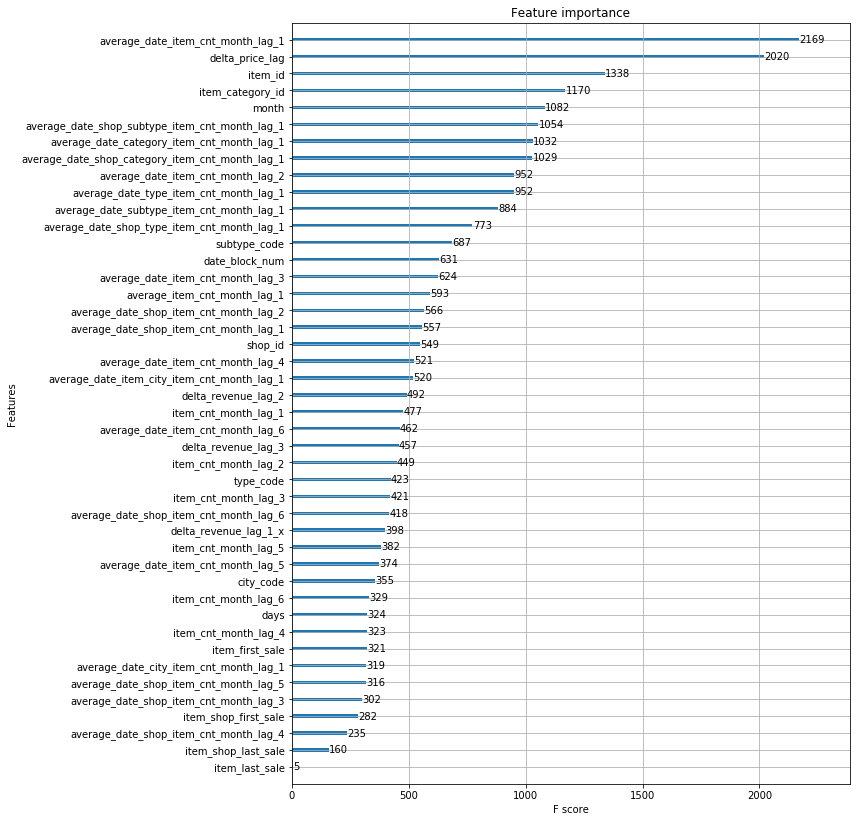

In [7]:
# 预测
ts = time.time()
test = pd.read_csv("test.csv")
y_test = XGBmodel.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID": test.index,
                         "item_cnt_month": y_test})
submission.to_csv("xgb_submission1.csv", index=False)
plot_features(XGBmodel, (10, 14))

time.time() - ts

In [8]:
gc.collect()

8413

In [9]:
# # use grid search
# ts = time.time()
# param_grid = [{"eta": [0.05, 0.1, 0.2, 0.3]}]
# XGBmodel = XGBRegressor(max_depth=8,
#                      n_estimators=1000, 
#                      min_child_weight=300,
#                      colsample_bytree=0.8,
#                      subsample=0.8,
#                      eta=0.2,
#                      seed=42,
#                         n_jobs=-1,
#                     )

# grid_search = GridSearchCV(XGBmodel, param_grid=param_grid, scoring="neg_mean_squared_error",
#                           n_jobs=-1, cv=3)
# grid_search.fit(X_train, y_train)

# time.time() - ts